In [26]:
import pandas as pd
import numpy as np
from scipy.sparse import dok_matrix, vstack

import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, \
recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

import matplotlib.pylab as plt
%matplotlib inline


In [2]:
phys = pd.read_csv('../../physicians.csv')
phys.info()

proc = pd.read_csv('../../procedures.csv')
proc.info()
# proc['procedure']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36025 entries, 0 to 36024
Data columns (total 2 columns):
id           36025 non-null int64
specialty    36025 non-null object
dtypes: int64(1), object(1)
memory usage: 563.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587774 entries, 0 to 587773
Data columns (total 4 columns):
physician_id          587774 non-null int64
procedure_code        587774 non-null object
procedure             587774 non-null object
number_of_patients    587774 non-null int64
dtypes: int64(2), object(2)
memory usage: 17.9+ MB


In [3]:
# split phsician data into unknown and known

# Get unknown index
_choose = ['Unknown' in specialty for specialty in phys['specialty']]
phys_unknown = phys[_choose]
phys_known = phys[[not ii for ii in _choose]]

# phys_unknown.info()

In [5]:

class ExtractWords(object):
    stopwords_set = set(stopwords.words('english'))
    _tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    
    def __init__(self):
        words = set()
        for ln in self._combine_proc(phys):
            words |= self.tokenize(ln)
        
        self.feature_words = list(sorted(words))
        self.num_features = len(self.feature_words)
        
        self._index_lookup = {f:index for index, f in enumerate(self.feature_words)}
    
    def tokenize(self, procedure):
        return set(self._tokenizer.tokenize(procedure)) - self.stopwords_set
        
    def get_feature_vector(self, procedure):
        # use sparse matrix to save space and time
        fvec = dok_matrix((1, self.num_features),dtype=np.float32)
        for f in self.tokenize(procedure):
            fvec[0, self._index_lookup[f]] = 1.
        
        return fvec
    
    def get_feature_matrix(self, procedures_list):
        blocks = [self.get_feature_vector(ii) for ii in procedures_list]
        return vstack(blocks)
    
    def _combine_proc(self, phy):
        return pd.merge(proc, phy, left_on='physician_id', right_on='id')[['physician_id', 'procedure']]\
    .groupby(by='physician_id').apply(lambda x: '_'.join(x['procedure']))
    
    def extract_X(self, phy):
        return self.get_feature_matrix(self._combine_proc(phy))
        

extractor = ExtractWords()

In [14]:
X = extractor.extract_X(phys_known)
X = X.toarray()

In [15]:
# Form the target vector (y)
def extract_targets(phys):
    return (phys['specialty'] == 'Cardiology').values

y = extract_targets(phys_known)

In [17]:
# Stratified shuffle-split into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    
    X_test = X[test_index,:]
    y_test = y[test_index]

In [20]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [21]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([ 0.96014039,  0.96365004,  0.97618451,  0.97041865,  0.96338099])

In [22]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

# calculate confusion matrix

print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_pred))
print("Precision Score: ", precision_score(y_train, y_train_pred))
print("Recall Score: ", recall_score(y_train, y_train_pred))
print("F1 Score: ", f1_score(y_train, y_train_pred))

Confusion Matrix: 
 [[13135   189]
 [  474  6145]]
Precision Score:  0.97016103568
Recall Score:  0.928387974014
F1 Score:  0.948814946344


In [24]:
# Precision/Recall tradeoff

y_scores_forest = cross_val_predict(sgd_clf, X_train, y_train, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

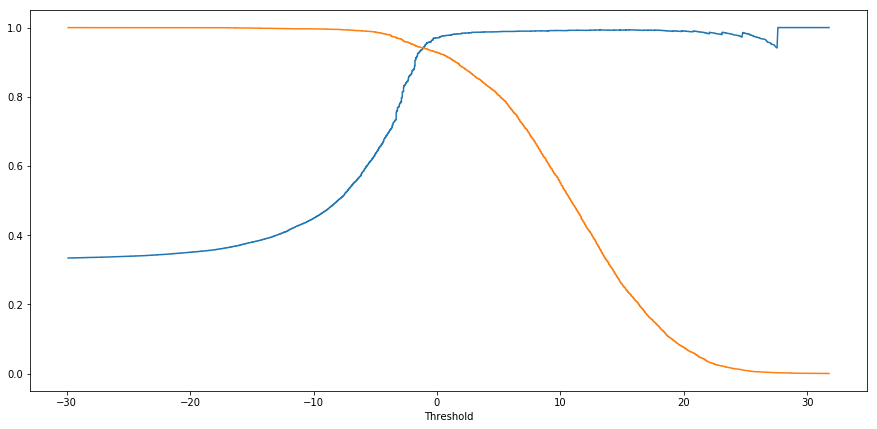

In [27]:
plt.figure(figsize=(15,7))
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.xlabel('Threshold')

In [28]:
X_ = extractor.extract_X(phys_unknown)
y_unknown_pred = sgd_clf.predict(X_)
print("Number of carodiologists found: ", y_unknown_pred.sum())

print(y_unknown_pred.sum()/len(y_unknown_pred))

Number of carodiologists found:  3344
0.301369863014
